# Supervised Learning Project

**by Octavio Garcia**

In [1]:
#Libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
food = pd.read_csv('./FAO.csv',encoding = "ISO-8859-1")

In [3]:
display(food.shape,food.dtypes)

(21477, 63)

Area Abbreviation     object
Area Code              int64
Area                  object
Item Code              int64
Item                  object
Element Code           int64
Element               object
Unit                  object
latitude             float64
longitude            float64
Y1961                float64
Y1962                float64
Y1963                float64
Y1964                float64
Y1965                float64
Y1966                float64
Y1967                float64
Y1968                float64
Y1969                float64
Y1970                float64
Y1971                float64
Y1972                float64
Y1973                float64
Y1974                float64
Y1975                float64
Y1976                float64
Y1977                float64
Y1978                float64
Y1979                float64
Y1980                float64
                      ...   
Y1984                float64
Y1985                float64
Y1986                float64
Y1987         

In [4]:
food.head()

,Area Abbreviation,Area Code,Area,Item Code,Item,Element Code,Element,Unit,latitude,longitude,...,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013
0,AFG,2,Afghanistan,2511,Wheat and products,5142,Food,1000 tonnes,33.94,67.71,...,3249.0,3486.0,3704.0,4164.0,4252.0,4538.0,4605.0,4711.0,4810,4895
1,AFG,2,Afghanistan,2805,Rice (Milled Equivalent),5142,Food,1000 tonnes,33.94,67.71,...,419.0,445.0,546.0,455.0,490.0,415.0,442.0,476.0,425,422
2,AFG,2,Afghanistan,2513,Barley and products,5521,Feed,1000 tonnes,33.94,67.71,...,58.0,236.0,262.0,263.0,230.0,379.0,315.0,203.0,367,360
3,AFG,2,Afghanistan,2513,Barley and products,5142,Food,1000 tonnes,33.94,67.71,...,185.0,43.0,44.0,48.0,62.0,55.0,60.0,72.0,78,89
4,AFG,2,Afghanistan,2514,Maize and products,5521,Feed,1000 tonnes,33.94,67.71,...,120.0,208.0,233.0,249.0,247.0,195.0,178.0,191.0,200,200


In [5]:
#df['Element'].unique()
#df['Item'].value_counts()
feats = food.columns
feats

Index(['Area Abbreviation', 'Area Code', 'Area', 'Item Code', 'Item',
       'Element Code', 'Element', 'Unit', 'latitude', 'longitude', 'Y1961',
       'Y1962', 'Y1963', 'Y1964', 'Y1965', 'Y1966', 'Y1967', 'Y1968', 'Y1969',
       'Y1970', 'Y1971', 'Y1972', 'Y1973', 'Y1974', 'Y1975', 'Y1976', 'Y1977',
       'Y1978', 'Y1979', 'Y1980', 'Y1981', 'Y1982', 'Y1983', 'Y1984', 'Y1985',
       'Y1986', 'Y1987', 'Y1988', 'Y1989', 'Y1990', 'Y1991', 'Y1992', 'Y1993',
       'Y1994', 'Y1995', 'Y1996', 'Y1997', 'Y1998', 'Y1999', 'Y2000', 'Y2001',
       'Y2002', 'Y2003', 'Y2004', 'Y2005', 'Y2006', 'Y2007', 'Y2008', 'Y2009',
       'Y2010', 'Y2011', 'Y2012', 'Y2013'],
      dtype='object')

In [10]:
selected_f = np.array(['Item','Element','Unit'])

In [12]:
tuples = selected_f.shape
tuples[0]

3

In [17]:
def selected_feat(selected,df):
    values = []
    leng = selected.shape
    for i in range(leng[0]):
        values.append(df[selected[i]].unique())
    return pd.DataFrame(values).T

In [19]:
selected_feat(selected_f,food).head()

,0,1,2
0,Wheat and products,Food,1000 tonnes
1,Rice (Milled Equivalent),Feed,None
2,Barley and products,None,None
3,Maize and products,None,None
4,Millet and products,None,None


In [20]:
food_drop = food.drop(['Area Abbreviation', 
                       'Area Code', 'Item Code',
                       'Element Code','Unit',
                       'latitude','longitude'],axis=1)
food_drop.head()

,Area,Item,Element,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,...,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013
0,Afghanistan,Wheat and products,Food,1928.0,1904.0,1666.0,1950.0,2001.0,1808.0,2053.0,...,3249.0,3486.0,3704.0,4164.0,4252.0,4538.0,4605.0,4711.0,4810,4895
1,Afghanistan,Rice (Milled Equivalent),Food,183.0,183.0,182.0,220.0,220.0,195.0,231.0,...,419.0,445.0,546.0,455.0,490.0,415.0,442.0,476.0,425,422
2,Afghanistan,Barley and products,Feed,76.0,76.0,76.0,76.0,76.0,75.0,71.0,...,58.0,236.0,262.0,263.0,230.0,379.0,315.0,203.0,367,360
3,Afghanistan,Barley and products,Food,237.0,237.0,237.0,238.0,238.0,237.0,225.0,...,185.0,43.0,44.0,48.0,62.0,55.0,60.0,72.0,78,89
4,Afghanistan,Maize and products,Feed,210.0,210.0,214.0,216.0,216.0,216.0,235.0,...,120.0,208.0,233.0,249.0,247.0,195.0,178.0,191.0,200,200


In [23]:
food_dropna = food_drop.dropna()
food_dropna.shape

(17938, 56)

In [24]:
food_dropna['Item'].value_counts()

Milk - Excluding Butter         450
Eggs                            298
Cereals - Excluding Beer        291
Fish, Seafood                   283
Maize and products              278
Pelagic Fish                    275
Oilcrops                        259
Cereals, Other                  255
Starchy Roots                   255
Animal fats                     241
Oats                            227
Fish, Body Oil                  225
Barley and products             223
Wheat and products              218
Rice (Milled Equivalent)        212
Pulses                          210
Oilcrops, Other                 209
Vegetables, Other               206
Cassava and products            206
Pulses, Other and products      206
Vegetables                      206
Potatoes and products           201
Fruits - Excluding Wine         188
Marine Fish, Other              186
Roots, Other                    184
Soyabeans                       180
Demersal Fish                   174
Rye and products            

In [25]:
items = ['Milk - Excluding Butter','Eggs','Cereals - Excluding Beer','Fish, Seafood',
         'Maize and products']

In [26]:
food_ = food_dropna[food_dropna['Item'].isin(items)]

In [38]:
bootcamp = pd.Series([18,18,22,22,23,25,25,26,27,30,33,35,38,39])

In [39]:
bootcamp.describe()

count    14.000000
mean     27.214286
std       6.852047
min      18.000000
25%      22.250000
50%      25.500000
75%      32.250000
max      39.000000
dtype: float64

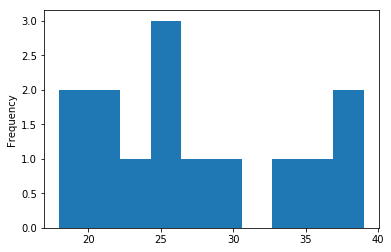

In [45]:
bootcamp.plot.hist(bins=10)